In [ ]:
#import library
import numpy as np 
import pandas as pd 
import os
from google.colab import drive 
from PIL import Image
import matplotlib.pyplot as plt
import random 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from sklearn.metrics import classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras import callbacks
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import rcParams

In [ ]:
#mount dataset import from the google drive
drive.mount('/content/drive')
!tar -xvf "/content/drive/MyDrive/utk-faces-cropped.tar.gz" -C "/content/"  
BASE_DIR = '/content/UTKFace'

Output streaming troncato alle ultime 5000 righe.
UTKFace/33_1_0_20170111182452825.jpg.chip.jpg
UTKFace/26_1_1_20170116024053194.jpg.chip.jpg
UTKFace/25_1_0_20170109213232182.jpg.chip.jpg
UTKFace/28_1_1_20170112234526480.jpg.chip.jpg
UTKFace/57_0_0_20170117191704100.jpg.chip.jpg
UTKFace/27_1_1_20170117193211345.jpg.chip.jpg
UTKFace/46_1_1_20170116161237892.jpg.chip.jpg
UTKFace/24_0_2_20170116171647508.jpg.chip.jpg
UTKFace/42_1_1_20170113005712902.jpg.chip.jpg
UTKFace/25_1_1_20170116001337504.jpg.chip.jpg
UTKFace/40_1_0_20170116222110661.jpg.chip.jpg
UTKFace/50_1_0_20170109012257664.jpg.chip.jpg
UTKFace/26_1_3_20170104235421282.jpg.chip.jpg
UTKFace/7_0_0_20170110215711115.jpg.chip.jpg
UTKFace/1_1_2_20161219155353413.jpg.chip.jpg
UTKFace/26_0_1_20170117195651493.jpg.chip.jpg
UTKFace/7_0_0_20170110215648859.jpg.chip.jpg
UTKFace/64_0_0_20170117155540137.jpg.chip.jpg
UTKFace/48_0_0_20170109004813150.jpg.chip.jpg
UTKFace/39_0_0_20170103183230555.jpg.chip.jpg
UTKFace/45_0_1_20170117190019363.

In [ ]:
# directory of the dataset
BASE_DIR = '/content/UTKFace'

In [ ]:
# map labels for gender and ethnicity
gender_dict = {
    0: 'Male', 
    1: 'Female'
}
ethnicity_dict = {
    0: 'European',
    1: 'African',
    2: 'Asian',
    3: 'Ocean',
    4: 'Other'
}

In [ ]:
# list labels: age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []
ethnicity_labels = []


# take the labels by the directory
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')

    #skip ds_store file
    if(filename == '.DS_Store'):
      continue

    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    
    #skip doblue underscore
    if(temp[1]== ''):
      continue
    
    #if the ethnicity not define assign class 'other'
    try:
      ethnicity = int(temp[2])
    except ValueError:
      ethnicity = 4

    #append labels in the list
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    ethnicity_labels.append(ethnicity)


In [ ]:
# convert to dataframe
df = pd.DataFrame()
# create dataframe for age, gender, ethnicity
df['image'], df['age'], df['gender'], df['ethnicity'] = image_paths, age_labels, gender_labels, ethnicity_labels
# print first 5 element df
df.head()

,image,age,gender,ethnicity
0,/content/UTKFace/2_1_0_20170109191715669.jpg.c...,2,1,0
1,/content/UTKFace/52_1_0_20170109220625669.jpg....,52,1,0
2,/content/UTKFace/2_1_4_20170103210129538.jpg.c...,2,1,4
3,/content/UTKFace/48_0_0_20170104193619832.jpg....,48,0,0
4,/content/UTKFace/2_1_0_20170109191520985.jpg.c...,2,1,0


In [ ]:
# take 10% of the data for validation
TEST_SPLIT = 0.1

# calcolate array lenght test
test_df_length = int(len(df) * TEST_SPLIT)

# shuffle df 
df = df.sample(frac=1)

# take 2 part and split in test and train 
test_df = df.head(test_df_length)
df = df.tail(len(df) - test_df_length)

print(len(df))

21338


image number:	 502
age:		 25
gender:		 Female


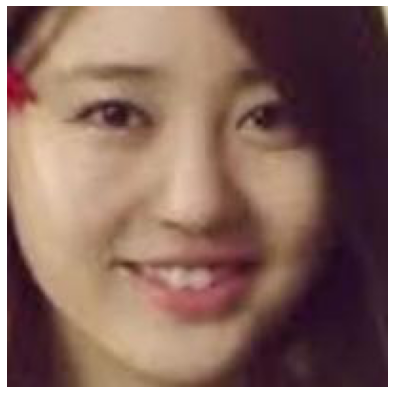

In [ ]:
# take random index for print photo of dataset
i = random.randint(0, len(df.index))

print('image number:\t', i)
print('age:\t\t', df['age'][i])
print('gender:\t\t', gender_dict[df['gender'][i]])

# show image
img = Image.open(df['image'][i])
plt.axis('off')
plt.imshow(img);

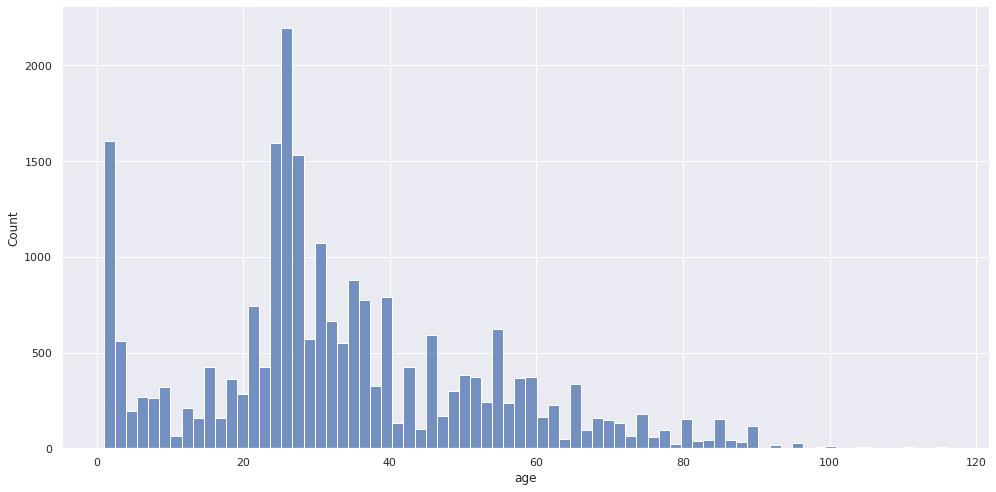

In [ ]:
# Graph age
sns.displot(df['age'], height=7, aspect=2)

In [ ]:
#Graph Gender
labels = ['Maschio', 'Femmina']
counts = df['gender'].value_counts().values.tolist()

pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
fig = go.Figure(data=[pie_plot])
fig.update_layout(title_text='Distribution for %s' % df['gender'].name)
    
fig.show()

In [ ]:
# Graph ethnicity
labels = ['Bianco', 'Nero', 'Asiatico', 'Indiano', 'Altro']
counts = df['ethnicity'].value_counts().values.tolist()

pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
fig = go.Figure(data=[pie_plot])
fig.update_layout(title_text='Distribution for %s' % df['ethnicity'].name)
    
fig.show()

In [ ]:
# for the last dataset split data for validation and train 
training_data, validation_data = train_test_split(df, test_size=0.2)

In [ ]:
# normalization of image (pixel from 0,1)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# assign dimension of batch
batch_size = 64

# take an image df and transform to tensor list by parameter for train and test 
train_generator = train_datagen.flow_from_dataframe(training_data,  
                                                    x_col = 'image', 
                                                    y_col = ['age', 'gender', 'ethnicity'], 
                                                    target_size = (128, 128),
                                                    class_mode = 'multi_output',
                                                    batch_size = batch_size)

val_generator = val_datagen.flow_from_dataframe(validation_data, 
                                                x_col = 'image', 
                                                y_col = ['age', 'gender', 'ethnicity'], 
                                                target_size = (128, 128),
                                                class_mode = 'multi_output',
                                                batch_size = batch_size)

Found 17070 validated image filenames.
Found 4268 validated image filenames.


In [ ]:
# transform df to nunmpy array
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])
y_ethnicity = np.array(df['ethnicity'])


In [ ]:
# create image shape 128x128x3 colors
input_shape = (128, 128, 3)

In [ ]:
# take input
inputs = Input((input_shape))

# create model sequential 
model = Sequential()

# create base model for all problems
base_model = Conv2D(32, (3, 3), activation = 'relu')(inputs)
base_model = MaxPooling2D((2, 2))(base_model)
base_model = Dropout(0.25)(base_model)
base_model = Conv2D(64, (3, 3), activation = 'relu')(base_model)
base_model = MaxPooling2D((2, 2))(base_model)
base_model = Dropout(0.25)(base_model)

# split model for age problem 
age_model = base_model
age_model = Conv2D(128, (3, 3), activation = 'relu')(age_model)
age_model = MaxPooling2D((2, 2))(age_model)
age_model = Dropout(0.3)(age_model)
age_model = Dropout(0.3)(age_model)
age_model = Flatten()(age_model)
age_model = Dense(128, activation = 'relu')(age_model)
age_model = Dense(64, activation = 'relu')(age_model)
age_model = Dense(32, activation = 'relu')(age_model)
age_model = Dense(1, activation = 'relu', name='age_output')(age_model)

# split model for gender problem
gender_model = base_model
gender_model = Conv2D(128, (3, 3), activation = 'relu')(gender_model)
gender_model = MaxPooling2D((2, 2))(gender_model)
gender_model = Dropout(0.3)(gender_model)
gender_model = Conv2D(64, (3, 3), activation = 'relu')(gender_model)
gender_model = MaxPooling2D((2, 2))(gender_model)
gender_model = Dropout(0.3)(gender_model)
gender_model = Flatten()(gender_model)
gender_model = Dense(32, activation = 'relu')(gender_model)
gender_model = Dense(16, activation = 'relu')(gender_model)
gender_model = Dense(8, activation = 'relu')(gender_model)
gender_model = Dense(1, activation = 'sigmoid', name='gender_output')(gender_model)

# split model for ethnicity problem
ethnicity_model = base_model
ethnicity_model = Conv2D(128, (3, 3), activation = 'relu')(ethnicity_model)
ethnicity_model = MaxPooling2D((2, 2))(ethnicity_model)
ethnicity_model = Dropout(0.2)(ethnicity_model)
ethnicity_model = Conv2D(64, (3, 3), activation = 'relu')(ethnicity_model)
ethnicity_model = MaxPooling2D((2, 2))(ethnicity_model)
ethnicity_model = Dropout(0.2)(ethnicity_model)
ethnicity_model = Flatten()(ethnicity_model)
ethnicity_model = Dense(64, activation = 'relu')(ethnicity_model)
ethnicity_model = Dropout(0.2)(ethnicity_model)
ethnicity_model = Dense(32, activation = 'relu')(ethnicity_model)
ethnicity_model = Dropout(0.2)(ethnicity_model)
ethnicity_model = Dense(16, activation = 'relu')(ethnicity_model)
ethnicity_model = Dropout(0.2)(ethnicity_model)
ethnicity_model = Dense(8, activation = 'relu')(ethnicity_model)
ethnicity_model = Dropout(0.2)(ethnicity_model)
ethnicity_model = Dense(5, activation = 'softmax', name='ethnicity_output')(ethnicity_model)

# generate output
model = Model(inputs=inputs, outputs=[age_model, gender_model, ethnicity_model])

# stop training when val_loss does not incrase 
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
# compile model 
model.compile(
    loss = {
        'age_output': 'mse',
        'gender_output': 'binary_crossentropy',
        'ethnicity_output': 'sparse_categorical_crossentropy'
    },
    optimizer = 'adam',
    metrics = {
        'age_output': 'mae',
        'gender_output': 'accuracy',
        'ethnicity_output': 'sparse_categorical_accuracy'
    },
    loss_weights= {
        'age_output': 4., 
        'ethnicity_output': 1.5, 
        'gender_output': 0.3
    }
)



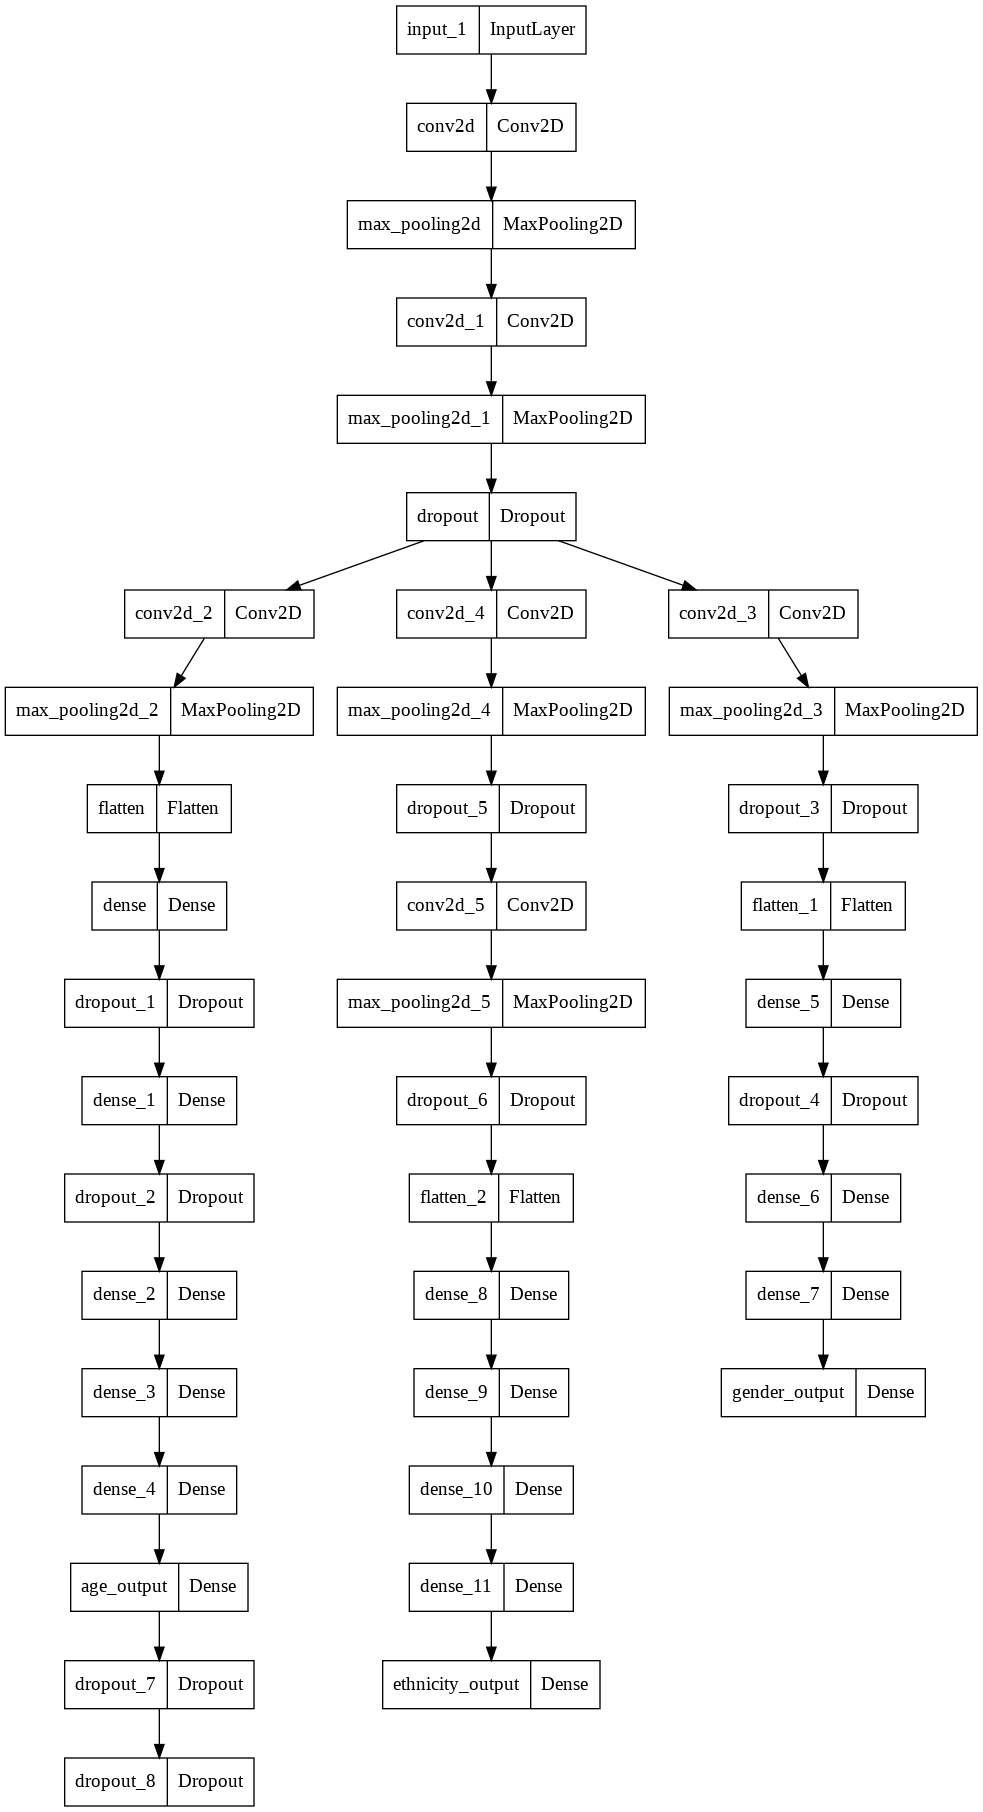

In [ ]:
# plot the model
plot_model(model)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
# train model
history = model.fit(train_generator, batch_size=64, epochs=100, validation_data=val_generator, callbacks=[earlystopping], workers=8)

Epoch 1/100
267/267 [==============================] - 23s 80ms/step - loss: 1655.2279 - age_output_loss: 413.2030 - gender_output_loss: 0.6321 - ethnicity_output_loss: 1.4838 - age_output_mae: 15.5224 - gender_output_accuracy: 0.6328 - ethnicity_output_sparse_categorical_accuracy: 0.4028 - val_loss: 2117.1196 - val_age_output_loss: 528.6929 - val_gender_output_loss: 0.5111 - val_ethnicity_output_loss: 1.4632 - val_age_output_mae: 17.2521 - val_gender_output_accuracy: 0.7678 - val_ethnicity_output_sparse_categorical_accuracy: 0.4241
Epoch 2/100
267/267 [==============================] - 22s 79ms/step - loss: 903.5481 - age_output_loss: 225.3255 - gender_output_loss: 0.4757 - ethnicity_output_loss: 1.4024 - age_output_mae: 11.1568 - gender_output_accuracy: 0.7718 - ethnicity_output_sparse_categorical_accuracy: 0.4477 - val_loss: 1326.8540 - val_age_output_loss: 331.1982 - val_gender_output_loss: 0.4047 - val_ethnicity_output_loss: 1.2930 - val_age_output_mae: 13.5701 - val_gender_output

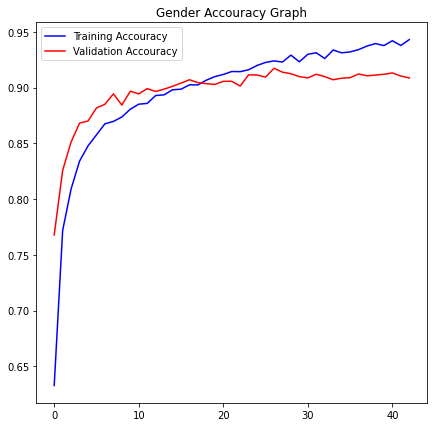

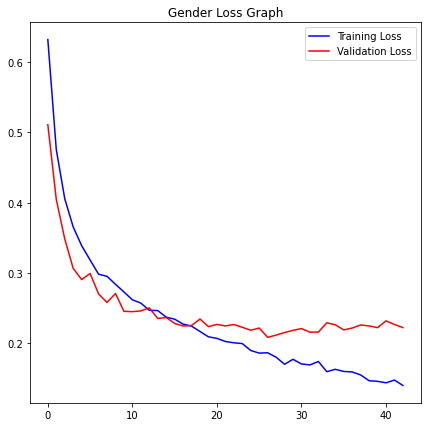

In [ ]:
#Gender Graph
acc = history.history['gender_output_accuracy']
val_acc = history.history['val_gender_output_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accouracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accouracy')
plt.title('Gender Accouracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_output_loss']
val_loss = history.history['val_gender_output_loss']

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Gender Loss Graph')
plt.legend()
plt.show()

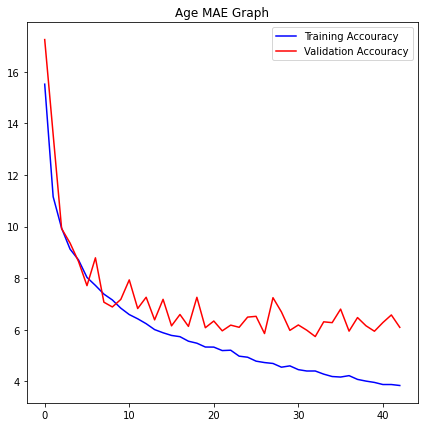

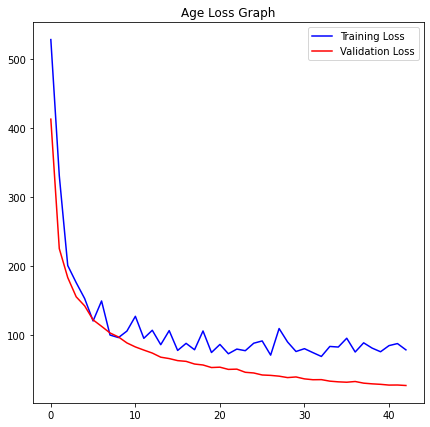

In [ ]:
#Age Graph
acc = history.history['age_output_mae']
val_acc = history.history['val_age_output_mae']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accouracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accouracy')
plt.title('Age MAE Graph')
plt.legend()
plt.figure()

loss = history.history['val_age_output_loss']
val_loss = history.history['age_output_loss']

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Age Loss Graph')
plt.legend()
plt.show()

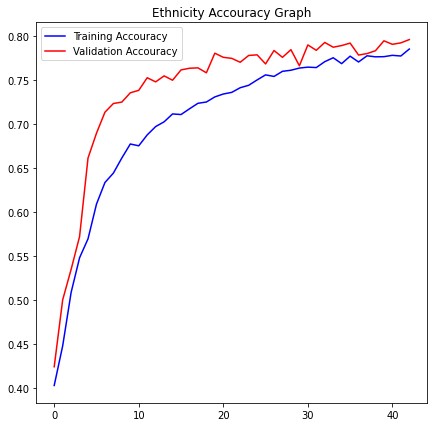

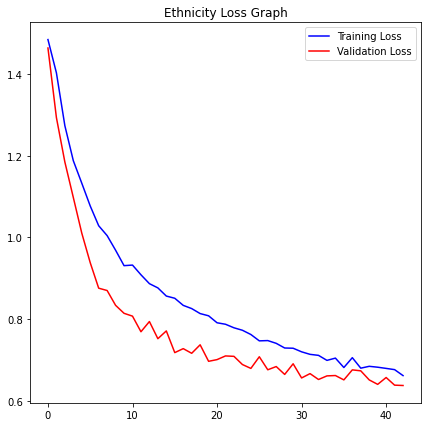

In [ ]:
#Ethnicity Graph
acc = history.history['ethnicity_output_sparse_categorical_accuracy']
val_acc = history.history['val_ethnicity_output_sparse_categorical_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label = 'Training Accouracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accouracy')
plt.title('Ethnicity Accouracy Graph')
plt.legend()
plt.figure()

loss = history.history['ethnicity_output_loss']
val_loss = history.history['val_ethnicity_output_loss']

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Ethnicity Loss Graph')
plt.legend()
plt.show()


In [ ]:
# save the model to h5 format by date time
from datetime import datetime

now = datetime.now() 

date_time = now.strftime("%Y%m%d%H%M%S")

path = '/content/models/' + date_time + '.h5'
print(path)

model.save(path, save_format='h5')

/content/models/20220707092119.h5


In [ ]:
# normalizzation dataset of test 
test_datagen = ImageDataGenerator(rescale=1./255)

# generator for dataset test initial 
test_genereator = test_datagen.flow_from_dataframe(test_df,  
                                                    x_col = 'image', 
                                                    y_col = ['age', 'gender', 'ethnicity'], 
                                                    target_size = (128, 128),
                                                    class_mode = 'multi_output',
                                                    shuffle=False,
                                                    batch_size = 64)

Found 2370 validated image filenames.


In [ ]:
# create predict for age, gender, ethnicity
age_preds, gender_preds, ethnicity_preds = model.predict_generator(test_genereator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
# create true labels and prediction label for the confusion matrix for this transforms the array to make them have the same shape. 
y_true_age = np.array(test_df['age'])
y_pred_age = age_preds.flatten().astype(int)

y_true_gender = np.array(test_df['gender'])
y_pred_gender = np.rint(np.array(gender_preds.flatten())).astype(int)

y_true_ethnicity = np.array(test_df['ethnicity'])

y_pred_ethnicity = []
for i in ethnicity_preds:
    y_pred_ethnicity.append(np.argmax(i))


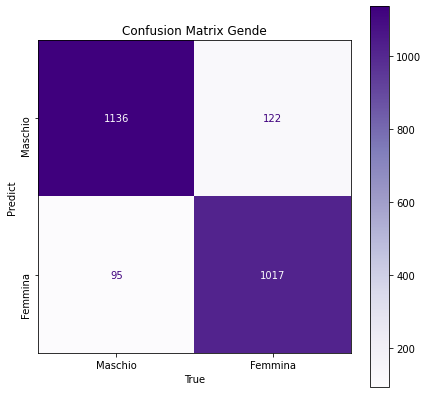

In [ ]:
# plot confusion matrix gender
cm = confusion_matrix(y_true_gender, y_pred_gender)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix Gende')
plt.yticks(np.arange(2), ['Maschio', 'Femmina'], rotation=90)
plt.xticks(np.arange(2), ['Maschio', 'Femmina'])
plt.xlabel('True')
plt.ylabel('Predict')
plt.show()


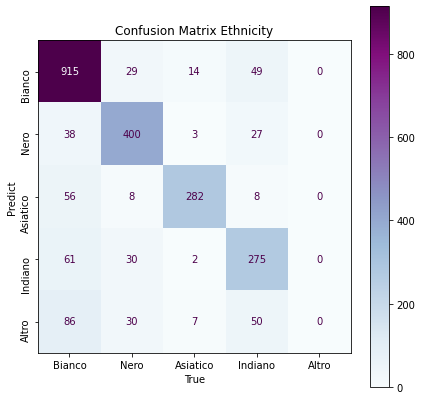

In [ ]:
# plot confusion matrix ethnicity
cm = confusion_matrix(y_true_ethnicity, y_pred_ethnicity)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.BuPu)
plt.title('Confusion Matrix Ethnicity')
plt.yticks(np.arange(5), ['Bianco', 'Nero', 'Asiatico', 'Indiano', 'Altro'], rotation=90)
plt.xticks(np.arange(5), ['Bianco', 'Nero', 'Asiatico', 'Indiano', 'Altro'])
plt.xlabel('True')
plt.ylabel('Predict')
plt.show()
plt.show()

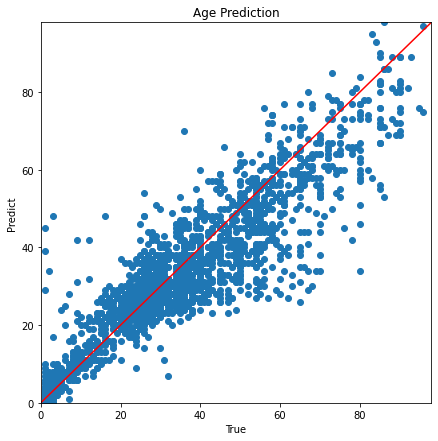

In [ ]:
# plot graph for the age
lineStart = y_pred_age.min()
lineEnd = y_pred_age.max()

plt.rcParams["figure.figsize"] = (7,7)
plt.figure()
plt.title('Age Prediction')
plt.scatter(y_true_age, y_pred_age)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.xlabel('True')
plt.ylabel('Predict')
plt.show()